# $\mathrm{EMDL \: \& \: Neural \: Network \: Inversion}$
## $\mathrm{RESOLVE \: \: Edition}$
## * Before you run all cells, please fill out INPUT CELL.

## Import Python Libraries

In [1]:
# Built-in : 
import sys, os
import json
import warnings
# Dependent : 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from tensorflow.keras.models import load_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# Local script : 
sys.path.append('../../')
from script import ModelingToolKit as mtk
from script import GenerateDataset as gd
from script import networks
from script import emplot
from script import emforward as emf
from script import emdlGL as gl
%matplotlib inline

## INPUT CELL

In [2]:
# name of this inversion (filename header)
name = 'sample'

In [3]:
### 1D HORIZONTAL MULTI-LAYERD STRUCTURE MODEL #####################
surface_layer_thickness = 0.5

final_boundary_depth = 150

number_of_layers = 30

split_scale = 'log'
# Thickness / manual
manual_thickness = []

# Resistivity range (Ohm-m)
resistivity_range = [1, 10000]

# Resistivity generation mode
generate_mode = 'TypeA'


### RESOLVE SYSTEM #################################################
# Bird height range (m)
bird_height_range = [20, 100]

# Operating Frequencies (Hz) / nominal frequencies : freqs = [140000, 40000, 8200, 3300, 1800, 400]
# VCA(VCX) Coil data around 3300 Hz is optional, but must be included at 4th index of the list.
freqs = [130100, 35920, 7970, 3528, 1822, 382]

# Operating Coil Separation (m) / nominal separation : spans = [7.86, 7.86, 7.86, 8.99, 7.86, 7.86]
# VCA(VCX) Coil data around 3300 Hz is optional, but must be included at 4th index of the list.
# Order must be the same as frequencies list.
spans = [7.86, 7.86, 7.86, 8.99, 7.86, 7.86]

# Gauss Noise Level
## average (ppm)
noise_ave = [0, 0, 0, 0, 0, 0]
## standard deviation (ppm)
noise_std = [50, 40, 20, 10, 10, 10]


### DEEP LEARNING ##################################################
# Dataset size
dataset_size = 5000
# Batch size
batch_size = 600
# Epochs
epochs = 50


### FIELD DATA FILE (CSV ONLY)######################################
# field or project name
field_name = 'murray_river'

# file path
fielddata_filepath = "../../field_data/bookpurnong_resolve.csv"

## HEADER ##
# Survey Line, FID, UTCtime
IDHeader = [
    'Line', 'fid', 'utctime'
]

# Bird UTM coordinate, Elevation (m)
LocHeader = [
    'bird_easting', 'bird_northing', 'elevation'
]

# Magnetic Field data (ppm)
EMHeader = [
    'em[10]', 'em[8]', 'em[6]', 'em[4]', 'em[2]', 'em[0]',
    'em[11]', 'em[9]', 'em[7]', 'em[5]', 'em[3]', 'em[1]',
]
# Bird Height (m)
BHHeader = 'bird_height'

# Missing Data Object
nan_char = ['*']

## Model Definition

In [4]:
warnings.simplefilter('ignore')
thickness = mtk.tmake(surface_layer_thickness, final_boundary_depth, number_of_layers, scale=split_scale)
if manual_thickness:
    thickness = manual_thickness
depth = mtk.dmake(thickness)
mtk.show_structure(thickness, depth)


Layer Boundary Depth (m)
  0.000 |   0.500 |   0.613 |   0.751 |   0.921 |   1.129 |   1.385 |   1.697 |   2.081 |   2.551 | 
  3.127 |   3.834 |   4.700 |   5.762 |   7.064 |   8.660 |  10.617 |  13.016 |  15.956 |  19.562 | 
 23.981 |  29.400 |  36.042 |  44.185 |  54.169 |  66.407 |  81.411 |  99.805 | 122.355 | 150.000 | 
Layer Thickness (m)
  0.500 |   0.113 |   0.138 |   0.170 |   0.208 |   0.255 |   0.313 |   0.384 |   0.470 |   0.576 | 
  0.707 |   0.866 |   1.062 |   1.302 |   1.596 |   1.957 |   2.399 |   2.941 |   3.605 |   4.420 | 
  5.418 |   6.643 |   8.143 |   9.983 |  12.239 |  15.004 |  18.394 |  22.550 |  27.645 | infinity|


## Generate Datasets

In [5]:
config = {
    'size' : dataset_size,
    'thicks' : thickness,
    'bgrlim' : resistivity_range,
    'bhlim' : bird_height_range,
    'freqs' : freqs,
    'spans' : spans,
    'noise_ave' : noise_ave,
    'noise_std' : noise_std,
    'generate_mode' : generate_mode
}

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
dataset_dir = 'result/'
dsetfile_path = dataset_dir + name + '_dataset.csv'

model_dir = 'network/'
histfile_path = model_dir + name + '_history.csv'
nnetfile_path = model_dir + name + '_network.h5'

if os.path.exists(dsetfile_path):
    df = pd.read_csv(dsetfile_path, header=None)
    network = load_model(nnetfile_path)
    hist_df = pd.read_csv(histfile_path)
    tofit = False
    print('The Specified Dataset & Neural Network Model Already Exists.')
else:
    resolve = gd.Resolve1D(**config)
    data = resolve.proceed()
    df = pd.DataFrame(data)
    df.to_csv(dsetfile_path, header=None, index=False)
    tofit = True
    print("-> /" + dsetfile_path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The Specified Dataset & Neural Network Model Already Exists.


## Deep Learning

In [6]:
# 説明変数の次元
bird_height_in_x = True
nx = 2 * len(freqs) + int(bird_height_in_x)
# 層数
nlayer = len(depth)

#分割
x = df.iloc[:, :nx].values
y = df.iloc[:, nx:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)
x_test_org = x_test.copy()
y_test_org = y_test.copy()

#正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

# 新しいデータセットが用意された場合、学習を実行する
if tofit:
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    network = networks.get_dnn(input_dim, output_dim)
    history = network.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_val, y_val))
    network.save(nnetfile_path)
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(histfile_path)


## Validation Test

<Figure size 432x288 with 0 Axes>

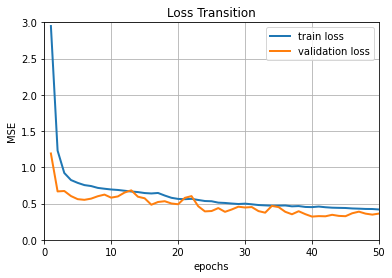

In [7]:
gl.loss_plot(hist_df, epochs)

## Analysing Field Data

In [8]:
save_path = "result/" + field_name + "_" + name + ".csv"

datafile_format = fielddata_filepath.split(sep='.')[-1]

pickup_columns = IDHeader + LocHeader + EMHeader + [BHHeader]
numlayer = len(depth)
RESHeader = ['R{}'.format(i+1) for i in range(numlayer)]

if bird_height_in_x:
    XVHeader = EMHeader + [BHHeader]
    YVHeader = RESHeader
else:
    XVHeader = EMHeader
    YVHeader = [BHHeader] + RESHeader

if os.path.exists(save_path):
    print('the result has already saved.')
    pass

else:
    if datafile_format == 'csv':
        data = pd.read_csv(fielddata_filepath)
        dfd = data.loc[:, pickup_columns].values
        df = pd.DataFrame(dfd, columns=pickup_columns)
        # 欠損値を含む行
        for c in nan_char:
            df = df.replace(c, np.nan)
        
        for xh in XVHeader:
            df = df[df[xh] != np.nan]

        x = df[XVHeader].values
        ide = df[IDHeader].values
        loc = df[LocHeader].values
        h = np.array([df[BHHeader].values]).T

        stdx = sc.transform(x)
        y = network.predict(stdx)
        y = 10 ** y

        header = [*IDHeader, *LocHeader, 'ALTBIRDO', *XVHeader, *YVHeader]
        rdata = np.hstack([ide, loc, h, x, y])
        rdf = pd.DataFrame(rdata)
        rdf.to_csv(save_path, header=header, index=False)
        print('the result is saved at ' + save_path)
    else:
        print('datafile format must be csv')

the result has already saved.


In [9]:
# 設定の保存
settings = {
    'network' : {
        'name' : name,
        'epochs' : epochs,
        'batch_size' : batch_size,

    },
    'subsurface' : {
        'thickness' : list(thickness),
        'depth' : list(depth)

    },
    'resolvedataset' : {
        'dataset_size' : dataset_size,
        'resistivity_range' : resistivity_range,
        'bird_height_range' : bird_height_range,
        'frequency' : freqs,
        'separetion' : spans,
        'noise_ave' : noise_ave,
        'noise_std' : noise_std,
        'generate_mode' : generate_mode,
        'bird_height_in_x' : bird_height_in_x
    },
    'fielddata' : {
        'field_name' : field_name,
        'fielddata_filepath' : fielddata_filepath,
        'nan_char' : nan_char
    }
}
if not os.path.exists(f'result/config_{name}_{field_name}.json'):
    with open(f'result/config_{name}_{field_name}.json', 'w') as fp:
        json.dump(settings, fp, indent=4)
else:
    print('Already saved')

Already saved


## Resistivity / Conductivity Depth Image

In [16]:
import scipy.constants as const
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, widgets, interact_manual
from IPython.display import display

df = pd.read_csv(save_path)
lines = df[IDHeader[0]].values
linetype = lines.dtype
if lines.dtype in [np.float64]:
    lines = lines.astype(np.int64)
lines = lines.astype(np.object)
line_no_list = []
logg = 0
for nomb in lines:
    if nomb == logg:
        logg = nomb
    else:
        line_no_list.append(nomb)
        logg = nomb

Value_min = [0.1, 1, 10, 100]
Value_max = [100, 1000, 10000, 100000]
Property = ['resistivity (Ohm-m)', 'conductivity (mS/m)']

# @interact(Line_No=line_no_list, Property=Property, Value_min=Value_min, Value_max=Value_max, )
def DIplot(Line_No, Property, Value_min, Value_max):
    inline = df[df[IDHeader[0]].astype(np.object)==Line_No]

    easting = inline[LocHeader[0]].values
    northing = inline[LocHeader[1]].values
    elevation = inline[LocHeader[2]].values
    linesize = len(easting)
    # from east
    if easting[0] > easting[-1]:
        start = linesize-1
    # from west
    else:
        start = 0

    distance = []
    start_east = easting[start]
    start_north = northing[start]
    for i in np.arange(0, linesize):
        dist = np.sqrt((northing[i]-start_north)**2 + (easting[i]-start_east)**2)
        distance.append(dist)
    distance = np.array(distance)

    theight = inline['ALTBIRDO'].values
    pheight = inline[BHHeader].values
    res = inline[RESHeader].values

    if Property == 'resistivity (Ohm-m)':
        cval = res
        cmap_name = 'jet_r'
        cmap = plt.cm.jet_r
    elif Property == 'conductivity (mS/m)':
        cval = 1/res*1000
        cmap_name = 'jet'
        cmap = plt.cm.jet

    cvalmax = Value_max
    cvalmin = Value_min

    cstd = (cval-cvalmin)/(cvalmax-cvalmin)
    cmaps = plt.cm.jet_r(cstd)

    depthadd = np.append(depth, 2*depth.max())
    fmin = min(freqs)

    plt.rcParams["font.size"] = 30
    plt.tight_layout()
    #plt.style.use('default')
    fig = plt.figure(figsize=(30, 8), dpi=100)
    ax = fig.add_subplot(111)
    norm = mpl.colors.LogNorm(vmin=cvalmin, vmax=cvalmax)
    for i in range(len(distance)-1):
        progress = int(i/(linesize-2)*100)
        print("\r"+"Progress ... "+str(progress)+" %",end="")
        # apparent skin dapth
        reg = theight[i]/np.sqrt(2e14/const.mu_0/np.pi/fmin)
        j = 0
        while (reg <= 1) and (j<29):
            reg += (depth[j+1] - depth[j]) / np.sqrt(res[i][j]/const.mu_0/np.pi/fmin)
            j += 1
        over = reg - 1
        overL = np.sqrt(res[i][j-1]/const.mu_0/np.pi/fmin) * over
        cval[i][j:] = np.nan
        depthadd = np.append(depth, 2*depth.max())
        depthadd[j] -= overL

        mesh_x, mesh_y = np.meshgrid(distance[i:i+2], -depthadd+elevation[i])
        cross_section = ax.pcolormesh(mesh_x, mesh_y, cval[i].reshape(len(cval[i]), 1), norm=norm, cmap=cmap_name, shading='flat')

    norm = mpl.colors.LogNorm(vmin=cvalmin, vmax=cvalmax)
    m = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    if type(Line_No) in [float, np.float64]:
        Line_No = int(Line_No)

    if Property == 'resistivity (Ohm-m)':
        cbar = fig.colorbar(m, cax=cax, label='Resistivity ($\Omega\cdot$m)', extend='both')
        ax.set_title('Resistivity Depth Image below Line ' + str(Line_No))
    elif Property == 'conductivity (mS/m)':
        cbar = fig.colorbar(m, cax=cax, label='Conductivity (mS/m)', extend='both')
        ax.set_title('Conductivity Depth Image below Line ' + str(Line_No))
        
    bird_line = elevation+theight
    ax.plot(distance, bird_line, color='k', label='bird elevation (observed)')

    ax.set(xlim=(distance.min(), distance.max()), ylim=(-40, bird_line.max()))
    ax.grid()
    ax.set_xlabel('West            Distance [m]            East')
    ax.set_ylabel('Elevation [m]')

    plt.show()

myim = interact_manual.options(manual_name='Show Image')
myim(DIplot, Line_No=line_no_list, Property=Property, Value_min=Value_min, Value_max=Value_max);

interactive(children=(Dropdown(description='Line_No', options=(30010, 30030, 30040, 30050, 30060, 30070, 30080…